# Creating a graph of brazilian cities

The main objective here is to use the brazilian map as an object for our MIP projects. We have already used population data at the state level in our [Congress](https://github.com/franciscogaluppo/MIP-Projects/blob/master/Congress.ipynb) project, but we can also use it at the municipality level. In particular, we can study how a population from a municipality relates to the neighboring municipalities.

For that, we need the graph for all municipalities in Brazil. IBGE (Brazilian Institute of Geography and Statistics) publishes every year a [*shape* file](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=acesso-ao-produto) of brazilian municipalities (the polygon shape for all municipalities). *libpysal* and *splot* can help us decide if two polygons (municipalities) share an edge (are neighbors).

Imports:

In [1]:
from libpysal.weights.contiguity import Rook
import libpysal
from splot.libpysal import plot_spatial_weights
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
%matplotlib inline

Let's have a look at our data:

In [2]:
gdf = gpd.read_file("Data/br_municipios_2018/BRMUE250GC_SIR.shp")
gdf.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABADIA DE GOIÁS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7..."
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1..."
2,ABADIÂNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0..."
3,ABAETÉ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8..."
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571..."


We have to remove two lagons that are part of the dataset (*Lagoa dos Patos* and *Lagoa Mirim*)

In [3]:
gdf = gdf.drop(gdf[(gdf["CD_GEOCMU"] == "4300001") | (gdf["CD_GEOCMU"] == "4300002")].index)

And also [Fernando de Noronha](https://en.wikipedia.org/wiki/Fernando_de_Noronha) and [Ilhabela](https://en.wikipedia.org/wiki/Ilhabela), which are islands (actually, both are archipelagos).

In [4]:
gdf = gdf.drop(gdf[(gdf["CD_GEOCMU"] == "2605459") | (gdf["CD_GEOCMU"] == "3520400")].index)
gdf.index = [x for x in range(len(gdf))]

Rook neighbors are those municipalities that share an edge on their respective borders:

In [5]:
weights = Rook.from_dataframe(gdf)

We can plot the graph over the map so we can get an idea of how it looks like.

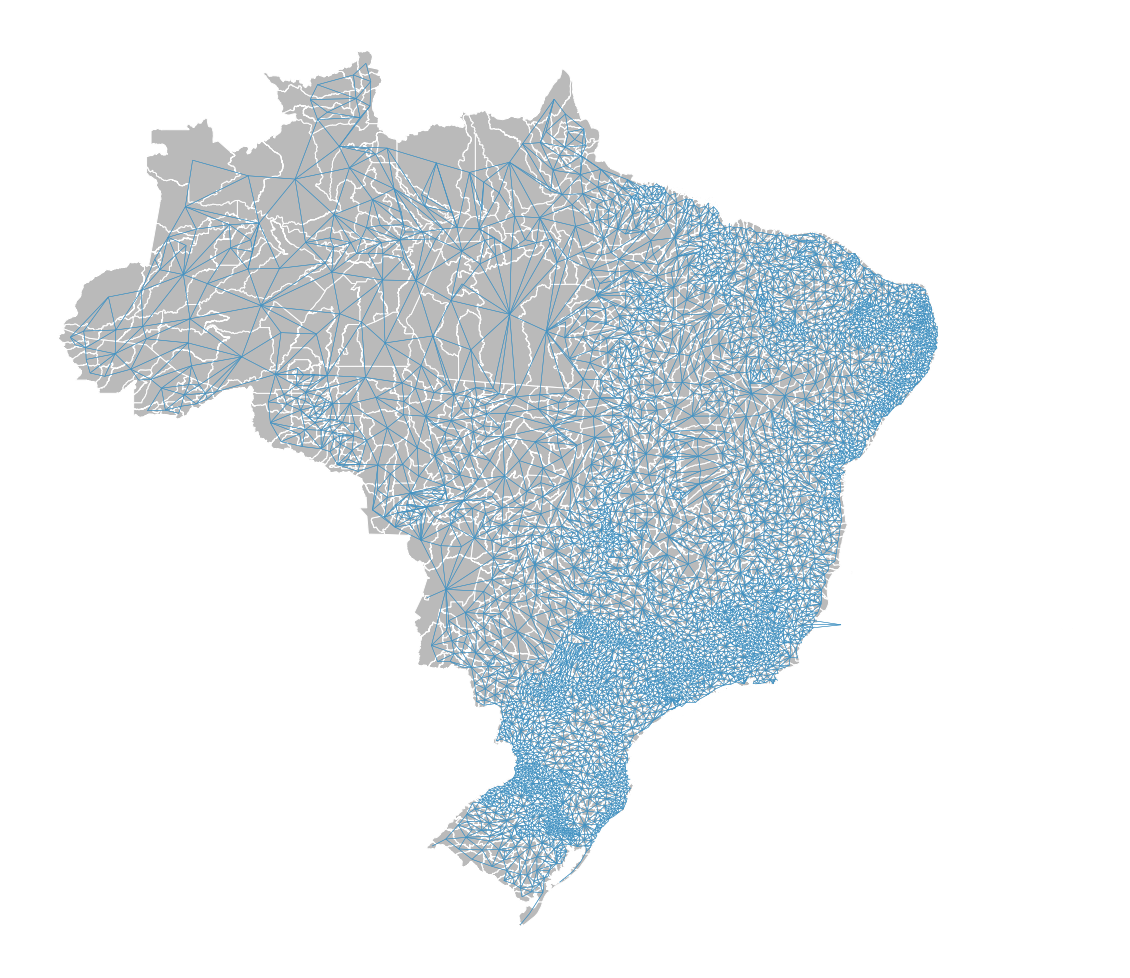

In [6]:
fig, ax = plot_spatial_weights(weights, gdf, nonplanar_edge_kws=dict(color='#4393c3', linewidth=1),
                     edge_kws=dict(color='#4393c3', linewidth=0.5),
                     node_kws=dict(marker=''))
fig.set_size_inches(20, 20)
plt.show()

Finally, we can convert it to a *networkx* graph object and export it for later use.

In [7]:
codes = gdf["CD_GEOCMU"].to_dict()
g = nx.relabel_nodes(weights.to_networkx(), codes)
nx.write_gml(g, "Data/Brazil.gml")